# Models using libraries

In [1]:
# importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os 
import random
import joblib
import torch
import gc
import statsmodels as sm

from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    precision_score,
    recall_score,
    average_precision_score,
)


# importing custom modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.data.load_data import load_data
from scipy.stats import randint, uniform

from src.models.MLP_torch import MLP, train_model
from src.models.Neg_bin_offest import neg_bin_model_offset
from src.models.Neg_bin import neg_bin_model
from src.models.Classifier_sklearn import RFC
from src.utils.tuning import run_random_search
from src.utils.evaluation import eval_regressor_model, logclaim_to_claimrate
from src.visualization.model_plots import plot_epoch_rmse, tail_residuals_plot, prediction_distribution, prediction_distribution_violin, parity_plot, residual_plot,  plot_learning_curve




In [2]:
target = "log_ClaimRate"

(X_train, y_train_log), (X_test, y_test_log)= load_data(raw=False, target=target)

## Decision tree from sklearn

We make the instance for the DT.

In [3]:
DT = DecisionTreeRegressor(random_state=42)
name = "Decision Tree Regressor from sklearn"

we also need to define our parameter distributions for RandomizedGridSearchCV.

In [4]:

param_dist_DT = {
    "max_depth": randint(10, 50),           # allow deeper trees
    "min_samples_split": randint(2, 20),    # slightly larger range to allow splitting
    "min_samples_leaf": randint(1, 10),     # smaller leaves to capture rare claims
    "max_features": ["sqrt", "log2", None], # keep as is
    "max_leaf_nodes": randint(50, 500),     # allow more leaves
    "ccp_alpha": uniform(0.0, 0.001)        # smaller pruning to prevent underfitting
}



### Training

And we run the hyperparameter tuning model using Randomized Search, and RMSE as the evaluation metric for 25 iterations.

In [5]:
if not os.path.exists("../models/best_DT_sklearn_model.joblib"):
    search = run_random_search(DT, param_dist_DT, X_train, y_train_log, n_iter=50, n_jobs=-1)

Now we have the best model.

In [6]:
# if a best model is already saved, load it
if os.path.exists("../models/best_DT_sklearn_model.joblib"):
    best_model_DT = joblib.load("../models/best_DT_sklearn_model.joblib")
else:
    best_model_DT = search.best_estimator_

In [7]:
best_model_DT.get_params()

{'ccp_alpha': 1.5966252220214196e-05,
 'criterion': 'squared_error',
 'max_depth': 11,
 'max_features': None,
 'max_leaf_nodes': 493,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 7,
 'min_samples_split': 13,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 42,
 'splitter': 'best'}

In [8]:
leaves = best_model_DT.get_n_leaves()
depth = best_model_DT.get_depth()
print(f"Best Decision Tree Model - Leaves: {leaves}, Depth: {depth}")

Best Decision Tree Model - Leaves: 24, Depth: 9


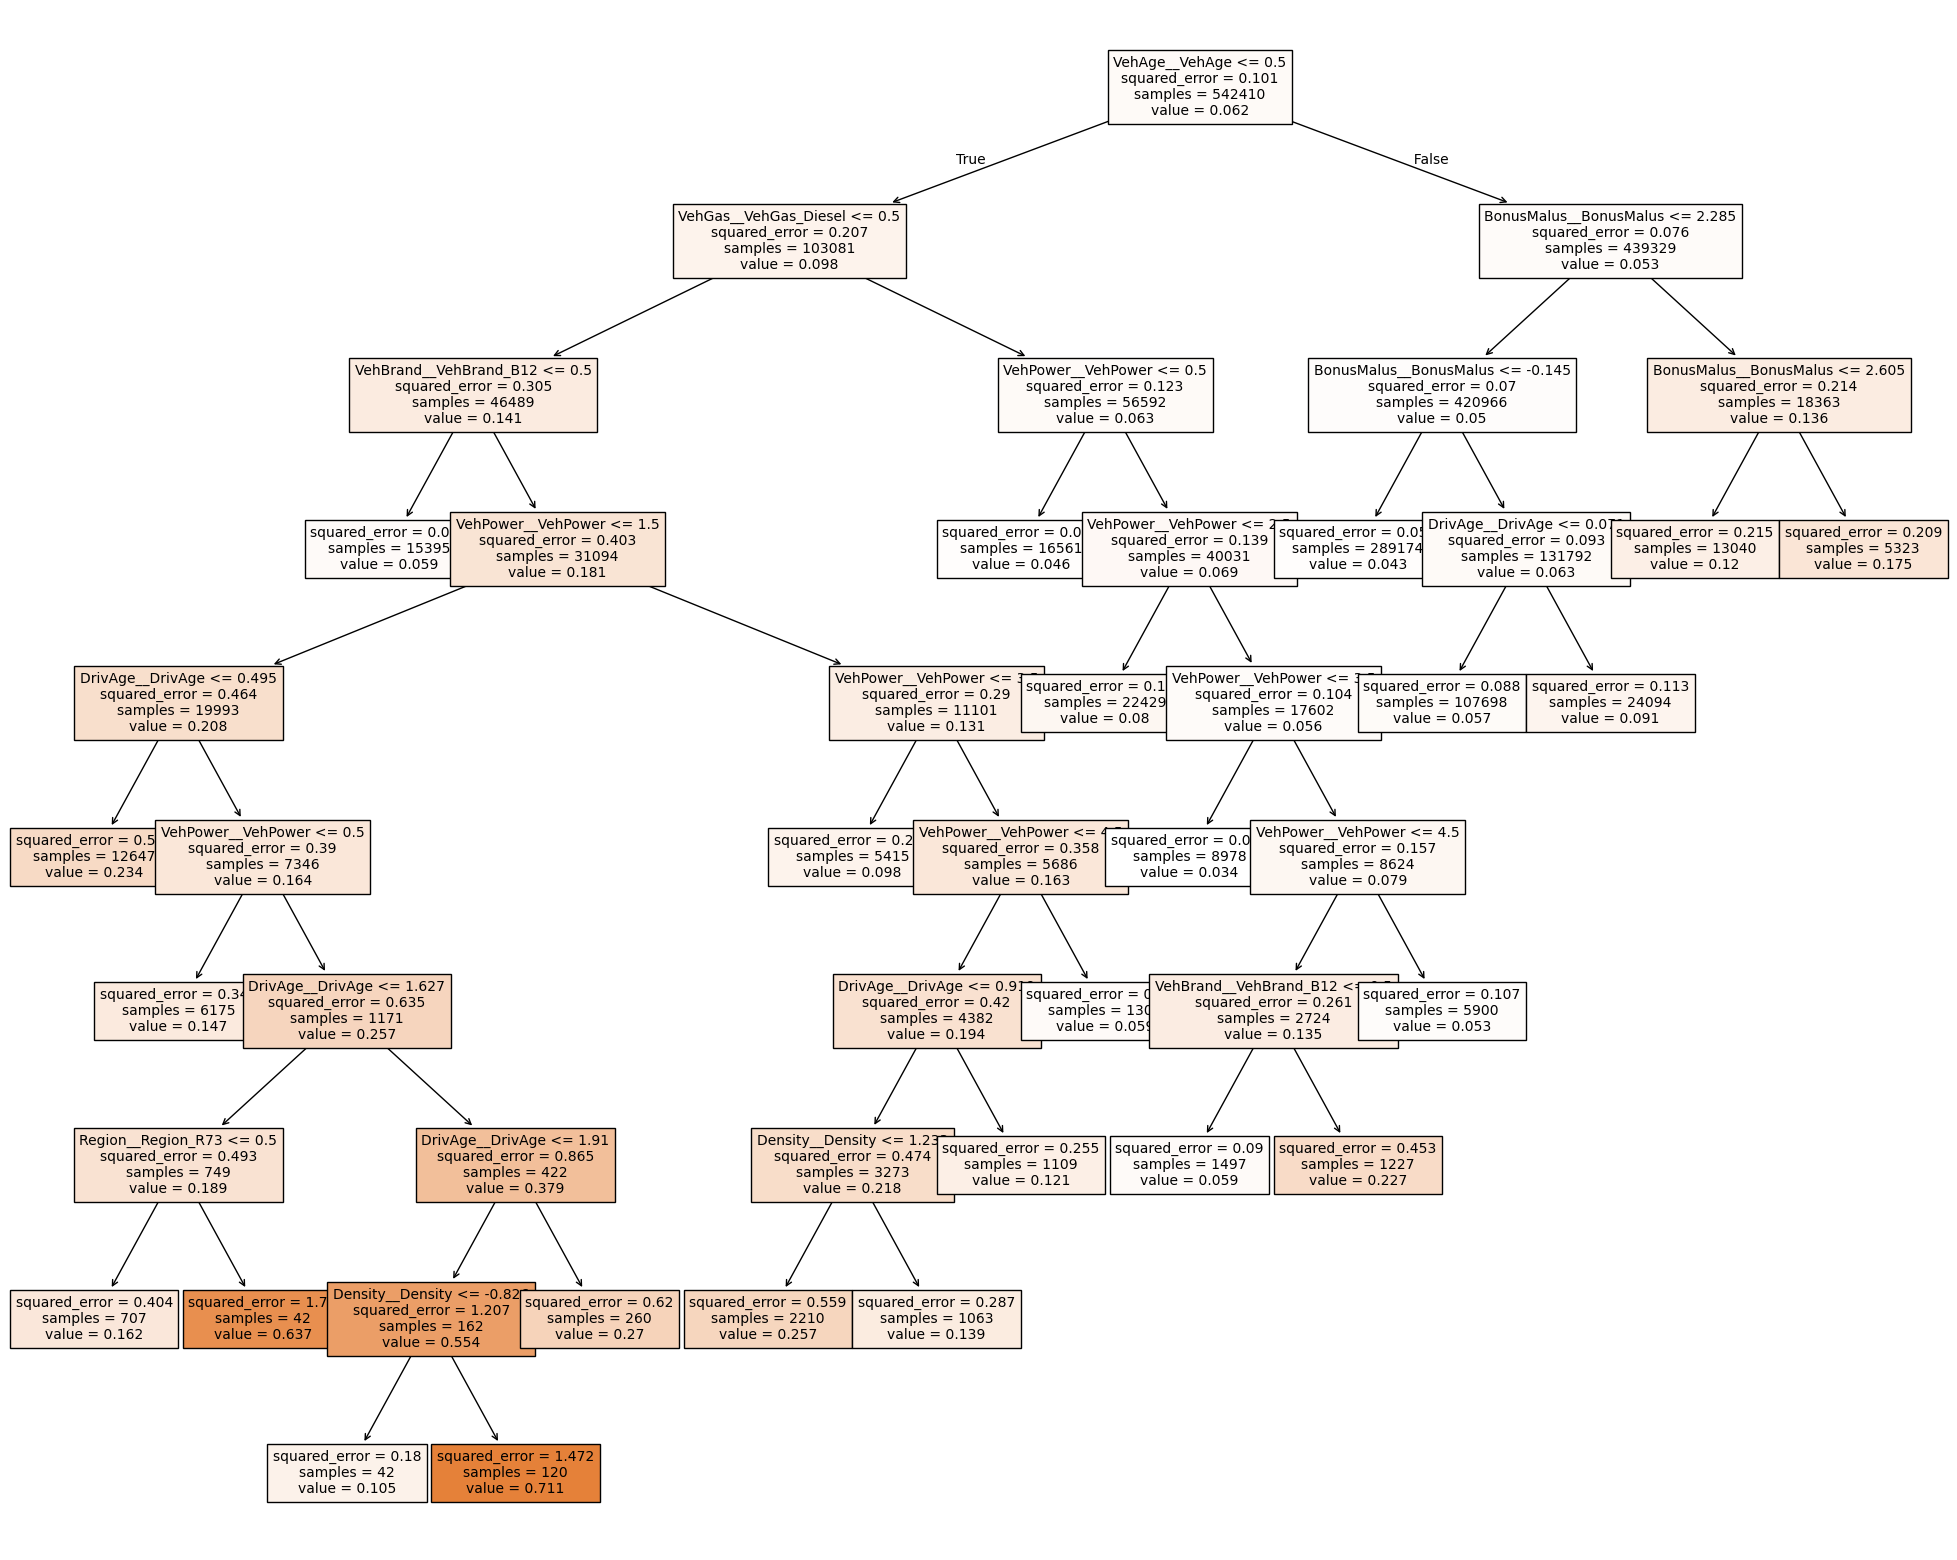

In [9]:
from sklearn import tree

preprocesser = joblib.load("../models/preprocesser_log_ClaimRate.joblib")
fig = plt.figure(figsize=(25, 20))
_ = tree.plot_tree(best_model_DT, filled=True, fontsize=10, feature_names=preprocesser.get_feature_names_out())


### Evaluation

Let's see how it did:

In [10]:
metrics_train_log, y_train_pred_log = eval_regressor_model(best_model_DT, X_train, y_train_log)
metrics_train_log

{'MAE': 0.11550840720398764, 'RMSE': 0.31530644292602256}

In [11]:
y_train_pred_log

array([0.05699581, 0.09079904, 0.05699581, ..., 0.05699581, 0.05699581,
       0.17500684])

Let's change our y values from the log world to claimrate.

In [12]:
y_train = logclaim_to_claimrate(y_train_log)
y_train_pred = logclaim_to_claimrate(y_train_pred_log)

In [13]:
max(y_train)

299.9999999999999

In [14]:
metrics_train = eval_regressor_model(model=None, X=None, y=y_train, y_pred=y_train_pred, log_given=False)
metrics_train

({'MAE': 0.29138727590257063, 'RMSE': 2.9124267039066574},
 array([0.05865137, 0.09504892, 0.05865137, ..., 0.05865137, 0.05865137,
        0.19125437]))

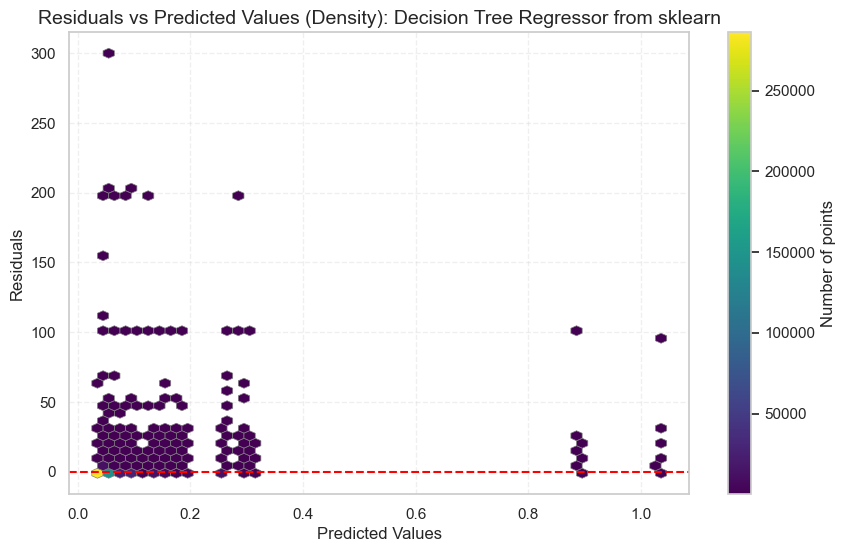

In [15]:
residual_plot(y_true=y_train, y_pred=y_train_pred, name=name)

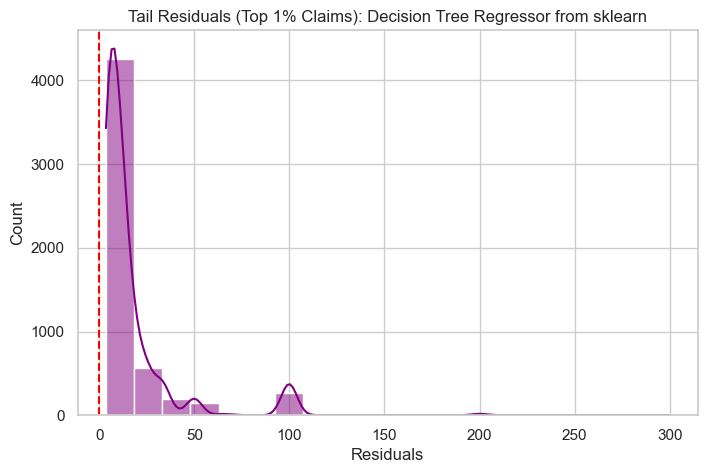

In [16]:
tail_residuals_plot(y_train, y_train_pred, name=name)

d:\ITU\2025-ITU-MachineLearning-Project-Claims-Risk-zrt\src\visualization\model_plots.py:65: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(
d:\ITU\2025-ITU-MachineLearning-Project-Claims-Risk-zrt\src\visualization\model_plots.py:87: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


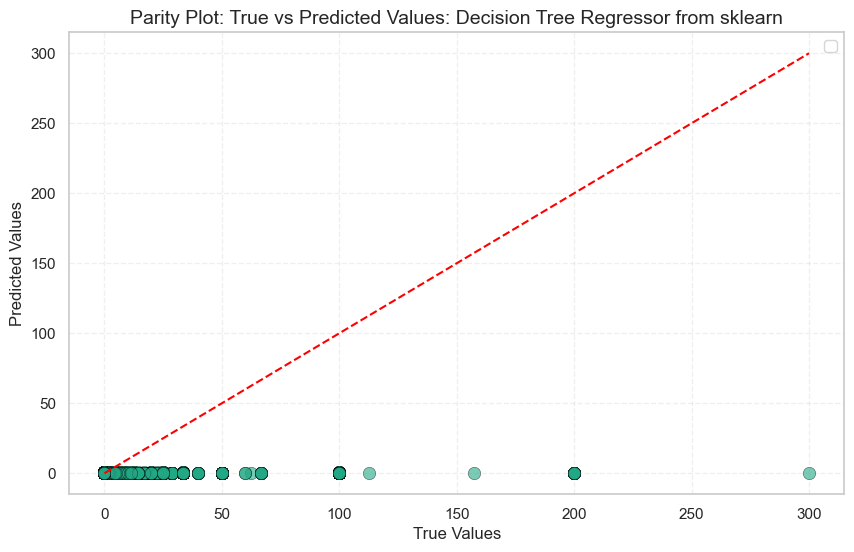

In [17]:
parity_plot(y_true=y_train, y_pred=y_train_pred, name=name)

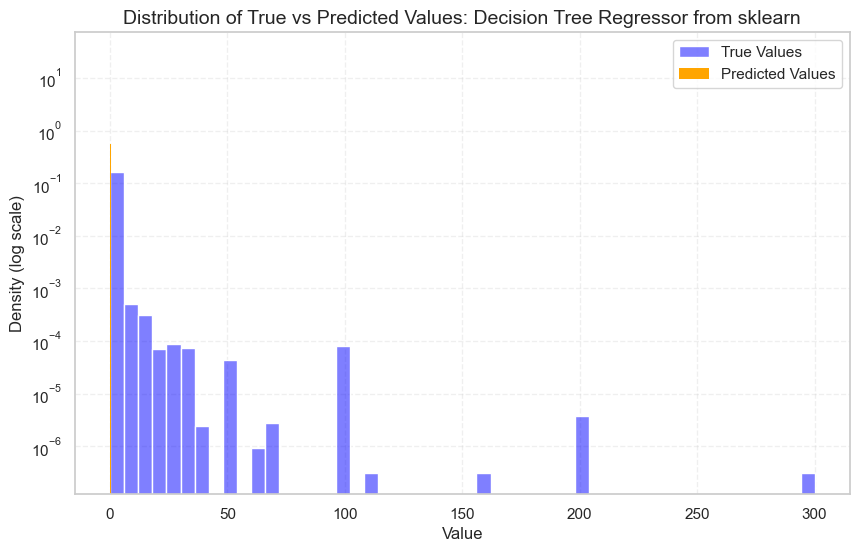

In [18]:
prediction_distribution(y_true=y_train, y_pred=y_train_pred, name=name)

d:\ITU\2025-ITU-MachineLearning-Project-Claims-Risk-zrt\src\visualization\model_plots.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Type', y='Value', data=df_melt, palette=['blue', 'orange'], inner='quartile')


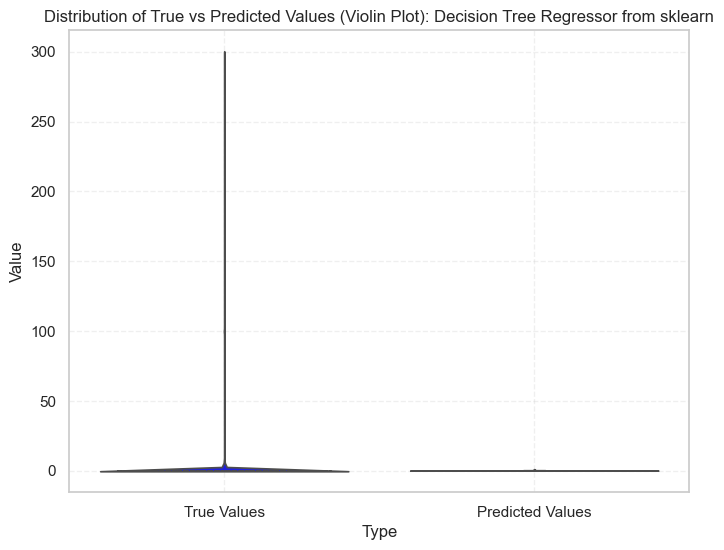

In [19]:
prediction_distribution_violin(y_true=y_train, y_pred=y_train_pred, name=name)

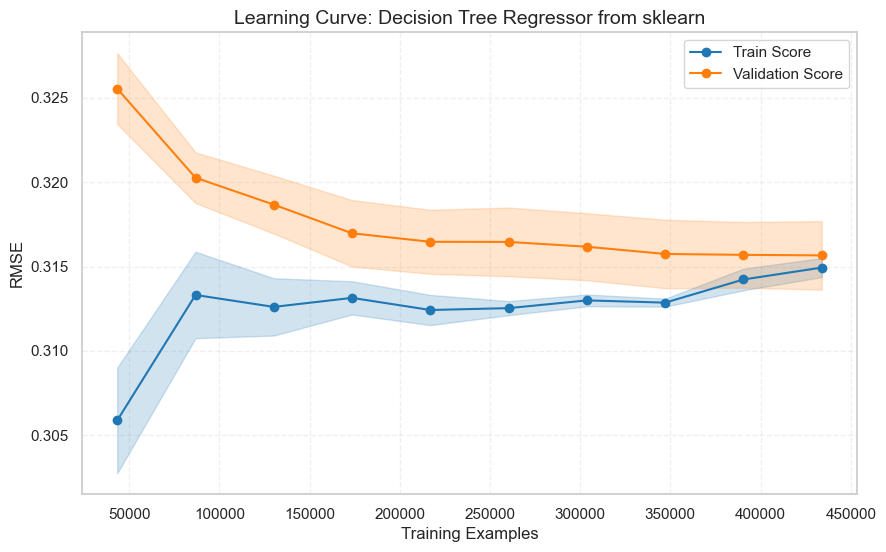

In [20]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
plot_learning_curve(model=best_model_DT, X=X_train, y=y_train_log, cv=cv, scoring="neg_root_mean_squared_error", name=name)

### Evaluation on testing set

Let's use our model on the test data.

In [21]:
y_test_pred_log = best_model_DT.predict(X_test)

In [22]:
y_test_pred = logclaim_to_claimrate(y_test_pred_log)
y_test = logclaim_to_claimrate(y_test_log)

In [23]:
eval_regressor_model(model=None, X=None, y=y_test, y_pred=y_test_pred, log_given=False)


({'MAE': 0.29711975250895495, 'RMSE': 3.0349186578791802},
 array([0.04431456, 0.05865137, 0.26385978, ..., 0.04431456, 0.060591  ,
        0.04431456]))

similar results.

Let's run the same plots.

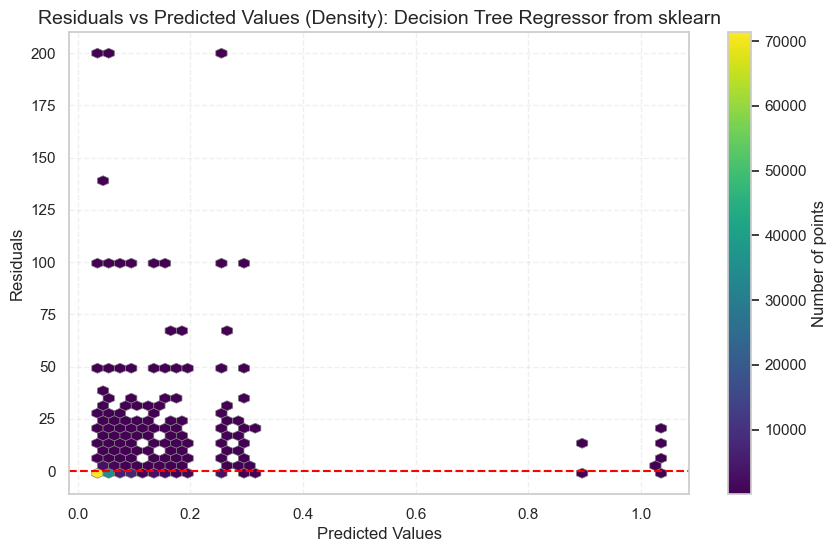

In [24]:
residual_plot(y_true=y_test, y_pred=y_test_pred, name=name)

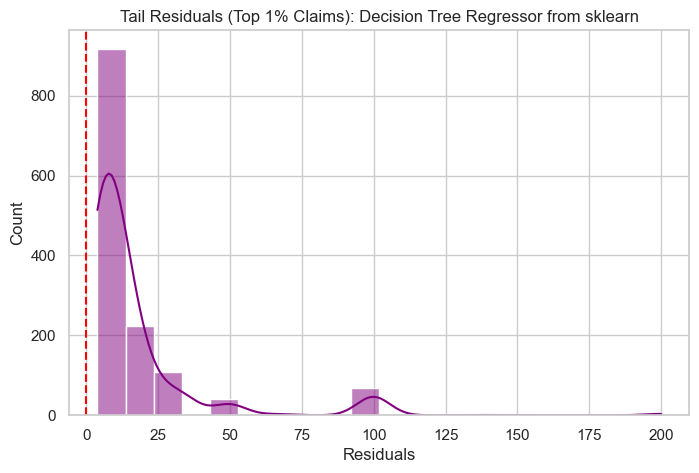

In [25]:
tail_residuals_plot(y_test, y_test_pred, name=name)

d:\ITU\2025-ITU-MachineLearning-Project-Claims-Risk-zrt\src\visualization\model_plots.py:65: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(
d:\ITU\2025-ITU-MachineLearning-Project-Claims-Risk-zrt\src\visualization\model_plots.py:87: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


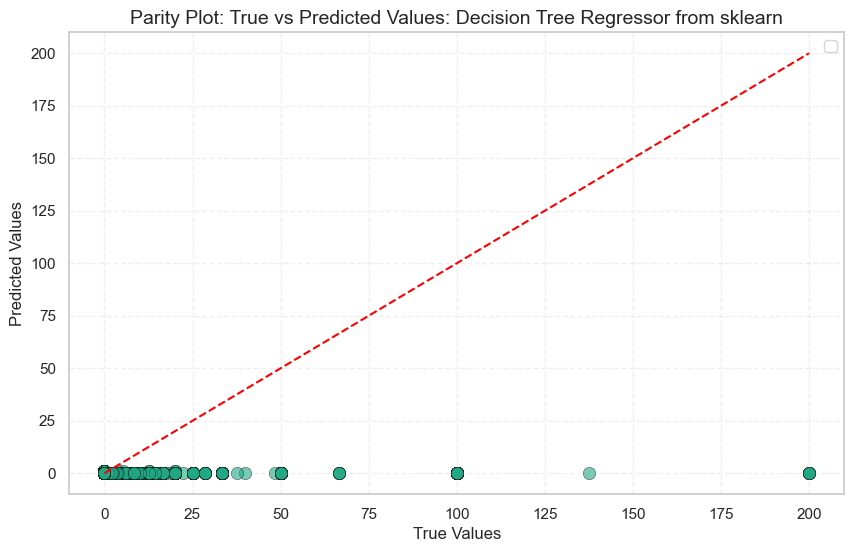

In [26]:
parity_plot(y_true=y_test, y_pred=y_test_pred, name=name)

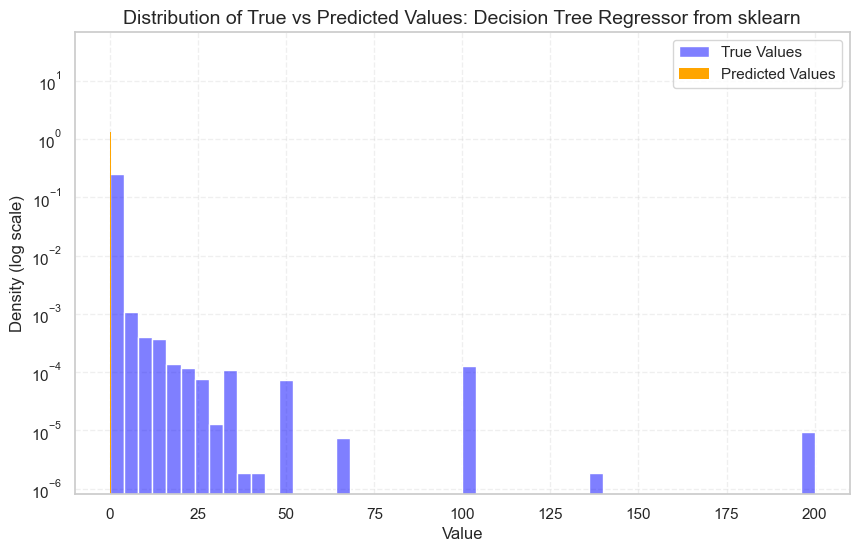

In [27]:
prediction_distribution(y_true=y_test, y_pred=y_test_pred, name=name)

d:\ITU\2025-ITU-MachineLearning-Project-Claims-Risk-zrt\src\visualization\model_plots.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Type', y='Value', data=df_melt, palette=['blue', 'orange'], inner='quartile')


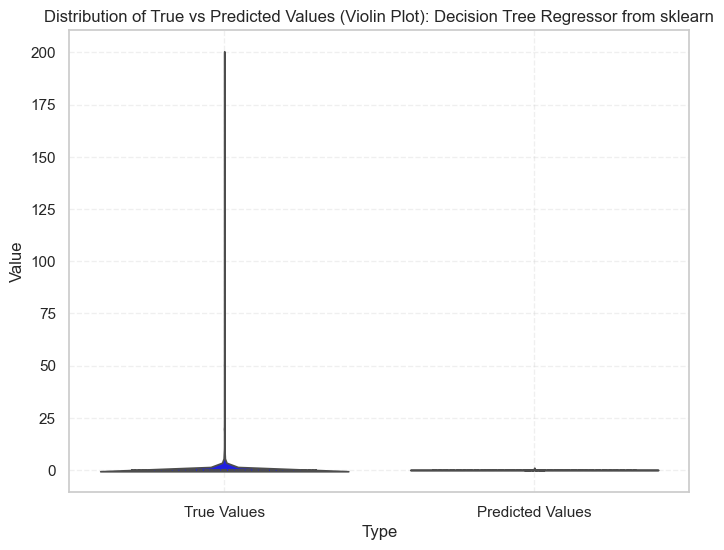

In [28]:
prediction_distribution_violin(y_true=y_test, y_pred=y_test_pred, name=name)

### Saving

And let's save our model as a joblib file.

In [29]:
if not os.path.exists("../models/best_DT_sklearn_model.joblib"):
    joblib.dump(best_model_DT, "../models/best_DT_sklearn_model.joblib")

## Neural Network from pytorch

In [3]:
input_size = X_train.shape[1]  
model = MLP(input_size=input_size)
print(model)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=35, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [9]:
param_grid = {
    'lr': [1e-3, 1e-4],
    'batch_size': [256, 512],
    'epochs': [50, 100],
    'hidden_sizes': [[64,32],[128,64],[256,128]],
}

n_iter = 10

### Training

We have to iterate manually here.

In [9]:
all_fold_train_rmse = []
all_fold_val_rmse = []
best_val_rmse = float('inf')
best_params = None
best_model_state = None
results = []

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for iter_idx in range(n_iter):
    # Sample hyperparameters
    hidden_sizes = random.choice(param_grid['hidden_sizes'])
    lr = random.choice(param_grid['lr'])
    batch_size = random.choice(param_grid['batch_size'])
    epochs = random.choice(param_grid['epochs'])

    fold_val_rmses = []
    fold_train_histories = []
    fold_val_histories = []

    print(f"\n=== Random Search Iteration {iter_idx+1}/{n_iter} ===")
    print(f"Params: hidden={hidden_sizes}, lr={lr}, batch={batch_size}, epochs={epochs}")

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        print(f"  Fold {fold_idx+1}/5")

        X_train_now, X_val = X_train[train_idx], X_train[val_idx]
        y_train_now, y_val = y_train_log[train_idx], y_train_log[val_idx]

        model = MLP(input_size=X_train.shape[1], hidden_sizes=hidden_sizes)

        model, train_rmse_list, val_rmse_list = train_model(
            model,
            X_train_now, y_train_now,
            X_val, y_val,
            lr=lr,
            batch_size=batch_size,
            epochs=epochs,
            return_epoch_history=True
        )

        fold_train_histories.append(train_rmse_list)
        fold_val_histories.append(val_rmse_list)

        fold_val_rmses.append(val_rmse_list[-1])
        print(f"    Fold final RMSE: {val_rmse_list[-1]:.4f}")
        
    mean_val_rmse = np.mean(fold_val_rmses)

    results.append({
        'hidden_sizes': hidden_sizes,
        'lr': lr,
        'batch_size': batch_size,
        'epochs': epochs,
        'mean_val_rmse': mean_val_rmse
    })

    print(f"  → Mean CV RMSE: {mean_val_rmse:.4f}")

    if mean_val_rmse < best_val_rmse:
        best_val_rmse = mean_val_rmse
        best_params = results[-1]
        best_model_state = model.state_dict()
        print("  ★ New best model found!")
        
    all_fold_train_rmse.append(fold_train_histories)
    all_fold_val_rmse.append(fold_val_histories)
print("\n=== Search Complete ===")
print("Best RMSE:", best_val_rmse)
print("Best params:", best_params)


=== Random Search Iteration 1/10 ===
Params: hidden=[64, 32], lr=0.0001, batch=512, epochs=100
  Fold 1/5
    Fold RMSE: 0.1018
  Fold 2/5
    Fold RMSE: 0.0979
  Fold 3/5
    Fold RMSE: 0.1000
  Fold 4/5
    Fold RMSE: 0.0993
  Fold 5/5
    Fold RMSE: 0.0993
  → Mean CV RMSE: 0.0997
  ★ New best model found!

=== Random Search Iteration 2/10 ===
Params: hidden=[64, 32], lr=0.0001, batch=512, epochs=50
  Fold 1/5
    Fold RMSE: 0.1018
  Fold 2/5
    Fold RMSE: 0.0977
  Fold 3/5
    Fold RMSE: 0.0999
  Fold 4/5
    Fold RMSE: 0.0992
  Fold 5/5
    Fold RMSE: 0.0994
  → Mean CV RMSE: 0.0996
  ★ New best model found!

=== Random Search Iteration 3/10 ===
Params: hidden=[256, 128], lr=0.001, batch=512, epochs=100
  Fold 1/5
    Fold RMSE: 0.1091
  Fold 2/5
    Fold RMSE: 0.1037
  Fold 3/5
    Fold RMSE: 0.1058
  Fold 4/5
    Fold RMSE: 0.1043
  Fold 5/5
    Fold RMSE: 0.1050
  → Mean CV RMSE: 0.1056

=== Random Search Iteration 4/10 ===
Params: hidden=[64, 32], lr=0.0001, batch=512, epoch

Now we have the best parameters, so let's initialize our final model.

In [ ]:
best_params

{'hidden_sizes': [256, 128],
 'lr': 0.001,
 'batch_size': 256,
 'epochs': 50,
 'mean_val_rmse': 0.31615666}

In [12]:
final_model = MLP(
    input_size=X_train.shape[1],
    hidden_sizes=best_params['hidden_sizes'],
)


Let's refit it on the whole training dataset.

In [22]:
final_model, train_rmse, _ = train_model(
    final_model,
    X_train,
    y_train_log,
    X_val=X_train,
    y_val=y_train_log,
    lr=best_params['lr'],
    batch_size=best_params['batch_size'],
    epochs=best_params['epochs']
)


In [ ]:
final_model.parameters

<bound method Module.parameters of MLP(
  (layers): Sequential(
    (0): Linear(in_features=35, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Softplus(beta=1.0, threshold=20.0)
  )
)>

### Evaluation

Let's evaluate on the training set.

In [37]:
with torch.no_grad():
    y_pred_log = final_model(
        torch.tensor(X_train, dtype=torch.float32)
    ).numpy().flatten()

y_train_pred = logclaim_to_claimrate(y_pred_log)
y_train = logclaim_to_claimrate(y_train_log)


In [48]:
y_train_pred = y_train_pred.clip(0, None)

In [ ]:
y_train.min()

0.0

In [ ]:
eval_regressor_model(model=None, X=None, y=y_train, y_pred=y_train_pred, log_given=False)

({'MAE': 0.2877402658297847, 'RMSE': 2.9148976241266062},
 array([0.07069623, 0.05860018, 0.12413777, ..., 0.10934982, 0.05829727,
        0.07042418], dtype=float32))

In [ ]:
residual_plot(y_true=y_train, y_pred=y_train_pred, name="MLP Regressor pytorch")

In [ ]:
tail_residuals_plot(y_train, y_train_pred, name="MLP Regressor pytorch")

In [ ]:
parity_plot(y_true=y_train, y_pred=y_train_pred, name="MLP Regressor pytorch")

In [ ]:
prediction_distribution(y_true=y_train, y_pred=y_train_pred, name="MLP Regressor pytorch")

In [ ]:
prediction_distribution_violin(y_true=y_train, y_pred=y_train_pred, name="MLP Regressor pytorch")

In [ ]:
plot_epoch_rmse(train_rmse_list, val_rmse_list)

TypeError: 'numpy.float32' object is not iterable

### Evaluation on testing set

In [ ]:
with torch.no_grad():
    y_test_pred_log = final_model(
        torch.tensor(X_test, dtype=torch.float32)
    ).numpy().flatten()

y_test_pred = logclaim_to_claimrate(y_test_pred_log)
y_test = logclaim_to_claimrate(y_test_log)


In [ ]:
eval_regressor_model(model=None, X=None, y=y_test, y_pred=y_test_pred, log_given=False)

({'MAE': 0.29341297323618604, 'RMSE': 3.037056628039101},
 array([0.0475811 , 0.07029036, 0.17950581, ..., 0.03407774, 0.06258205,
        0.08970315], dtype=float32))

In [ ]:
residual_plot(y_true=y_test, y_pred=y_test_pred, name="MLP Regressor pytorch")

In [ ]:
tail_residuals_plot(y_test, y_test_pred, name="MLP Regressor pytorch")

In [ ]:
parity_plot(y_true=y_test, y_pred=y_test_pred, name="MLP Regressor pytorch")

In [ ]:
prediction_distribution(y_true=y_test, y_pred=y_test_pred, name="MLP Regressor pytorch")

In [ ]:
prediction_distribution_violin(y_true=y_test, y_pred=y_test_pred, name="MLP Regressor pytorch")

### Saving

In [ ]:
torch.save({
    'model_state_dict': final_model.state_dict(),
    'input_size': X_train.shape[1],
    'hidden_sizes': best_params['hidden_sizes']
}, '../models/best_mlp_pytorch_model.pt')

## Let's move onto the negative binomial model with offset

In [3]:
target = "ClaimNb"

(X_train, y_train), (X_test, y_test) = load_data(raw=False, target=target)

In [4]:
import scipy.sparse as sp

def pop_column(X, col_idx):
    if sp.issparse(X):
        exposure = np.asarray(X[:, col_idx].toarray()).ravel()
        X_wo = sp.hstack([X[:, :col_idx], X[:, col_idx+1:]], format="csr")
        return X_wo, exposure
    else:
        X = np.asarray(X)
        exposure = X[:, col_idx].ravel()
        X_wo = np.delete(X, col_idx, axis=1)
        return X_wo, exposure


X_train, exposure_train = pop_column(X_train, 0)
X_test,  exposure_test  = pop_column(X_test, 0)


In [5]:
train_df, test_df= load_data(raw=True, target=target)
exposure_raw = train_df["Exposure"].to_numpy()

In [2]:
def negbin_deviance(y_true, y_pred, alpha, eps=1e-12):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    y_pred = np.clip(y_pred, eps, None)

    mask = y_true > 0
    dev = np.zeros_like(y_true)

    dev[mask] = (
        y_true[mask] * np.log(y_true[mask] / y_pred[mask])
        - (y_true[mask] + 1.0 / alpha)
        * np.log((1 + alpha * y_true[mask]) / (1 + alpha * y_pred[mask]))
    )

    dev[~mask] = (1.0 / alpha) * np.log(1 + alpha * y_pred[~mask])

    return 2 * np.mean(dev)

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [ ]:
if not os.path.exists("../models/final_nb_glm_pd_o.joblib"):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_rmses = []
    fold_devs = []

    for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train)):
        X_tr, X_val = X_train[tr_idx], X_train[val_idx]
        y_tr, y_val = y_train[tr_idx], y_train[val_idx]

        exp_tr = exposure_raw[tr_idx]
        exp_val = exposure_raw[val_idx]

        model = neg_bin_model_offset(X_tr, y_tr, exp_tr)
        
        res = model.fit()
        preds = model.predict(X_val, exp_val)
        alpha = res.scale


        model_dev = negbin_deviance(y_val, preds, alpha)
        fold_rmses.append(rmse(y_val, preds))

        mu_null_rate = np.sum(y_tr) / np.sum(exp_tr)
        null_preds = mu_null_rate * exp_val

        null_dev = negbin_deviance(y_val, null_preds, alpha)

        print(
            f"Fold {fold}: null={null_dev:.3f}, model={model_dev:.3f}, "
            f"impr={(null_dev-model_dev)/null_dev*100:.1f}%"
        )

        fold_devs.append(model_dev)

    print("CV NB deviance mean:", np.mean(fold_devs))
    print("CV NB deviance std :", np.std(fold_devs))

    print("CV RMSE mean:", np.mean(fold_rmses))
    print("CV RMSE std :", np.std(fold_rmses))

c:\Users\etiko\anaconda3\envs\torchenv\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Fold 0: null=0.292, model=0.283, impr=3.1%


c:\Users\etiko\anaconda3\envs\torchenv\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Fold 1: null=0.283, model=0.273, impr=3.4%


c:\Users\etiko\anaconda3\envs\torchenv\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Fold 2: null=0.290, model=0.280, impr=3.2%


c:\Users\etiko\anaconda3\envs\torchenv\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Fold 3: null=0.288, model=0.279, impr=3.2%


c:\Users\etiko\anaconda3\envs\torchenv\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Fold 4: null=0.290, model=0.280, impr=3.5%
CV NB deviance mean: 0.27913067182785334
CV NB deviance std : 0.0032379069953904632
CV RMSE mean: 0.23784176771968463
CV RMSE std : 0.0027730239908353924


In [8]:
if not os.path.exists("../models/final_nb_offset.joblib"):    
    final_model = neg_bin_model_offset(X_train, y_train, exposure=exposure_train)
    final_fit = final_model.fit()

c:\Users\etiko\anaconda3\envs\torchenv\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [9]:
# if a best model is already saved, load it
if os.path.exists("../models/final_nb_offset.joblib"):
    best_model_NB = joblib.load("../models/final_nb_offset.joblib")
else:
    best_model_NB = final_model

In [11]:
y_train_pred = best_model_NB.predict(X_train, exposure_train)

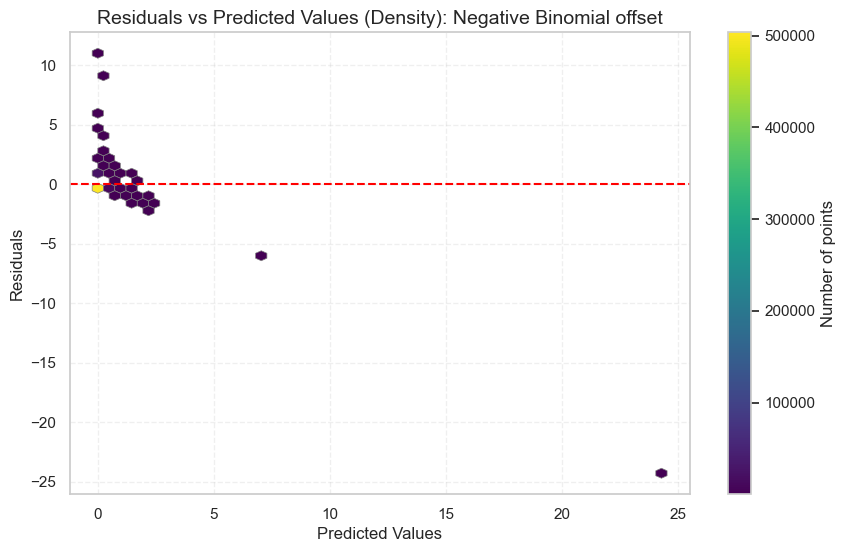

In [12]:
residual_plot(y_true=y_train, y_pred=y_train_pred, name="Negative Binomial offset")

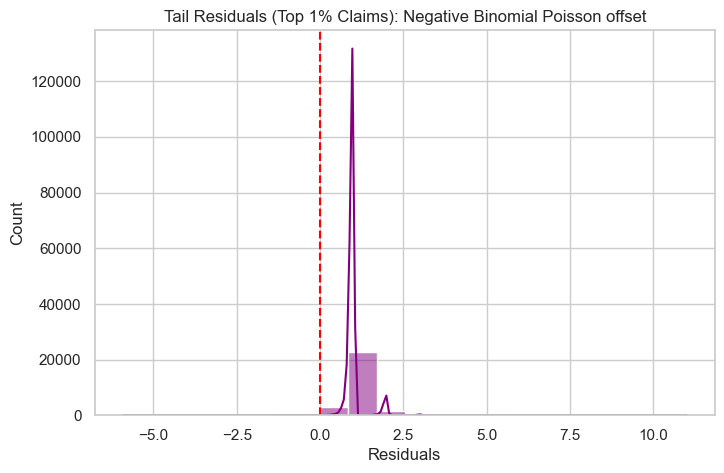

In [13]:
tail_residuals_plot(y_train, y_train_pred, name="Negative Binomial Poisson offset")

d:\ITU\2025-ITU-MachineLearning-Project-Claims-Risk-zrt\src\visualization\model_plots.py:65: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(
d:\ITU\2025-ITU-MachineLearning-Project-Claims-Risk-zrt\src\visualization\model_plots.py:87: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


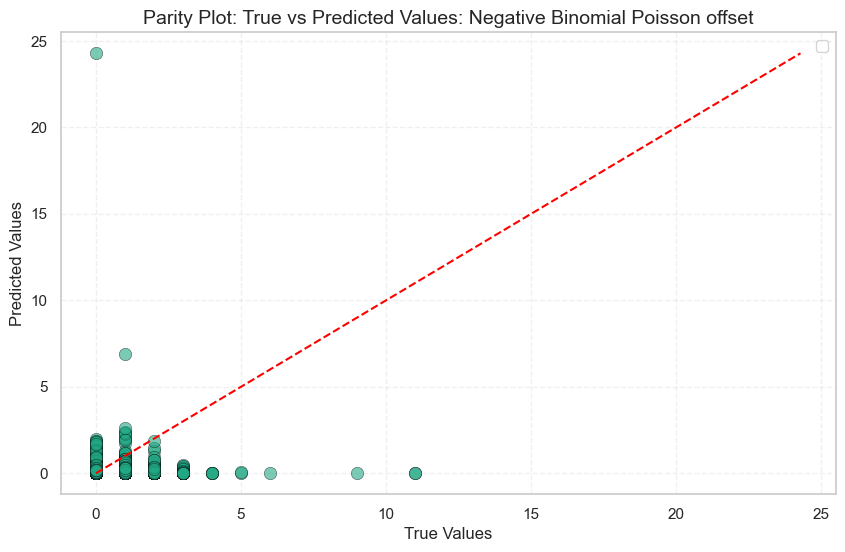

In [14]:
parity_plot(y_true=y_train, y_pred=y_train_pred, name="Negative Binomial Poisson offset")

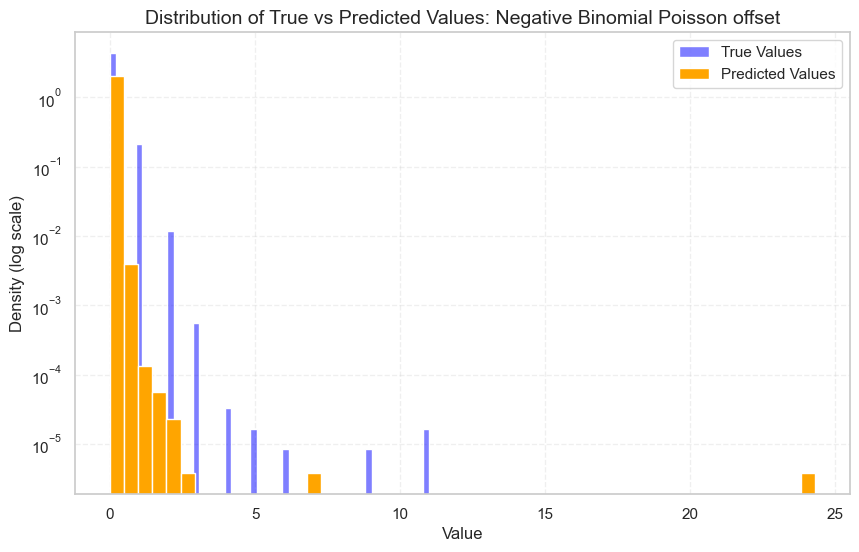

In [15]:
prediction_distribution(y_true=y_train, y_pred=y_train_pred, name="Negative Binomial Poisson offset")

d:\ITU\2025-ITU-MachineLearning-Project-Claims-Risk-zrt\src\visualization\model_plots.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Type', y='Value', data=df_melt, palette=['blue', 'orange'], inner='quartile')


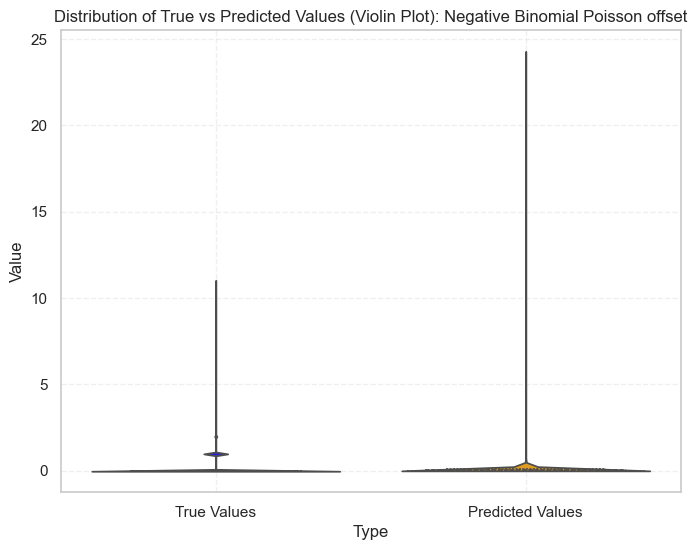

In [16]:
prediction_distribution_violin(y_true=y_train, y_pred=y_train_pred, name="Negative Binomial Poisson offset")

## Evaluation on test set

In [18]:
y_test_pred = best_model_NB.predict(X_test, exposure_test)

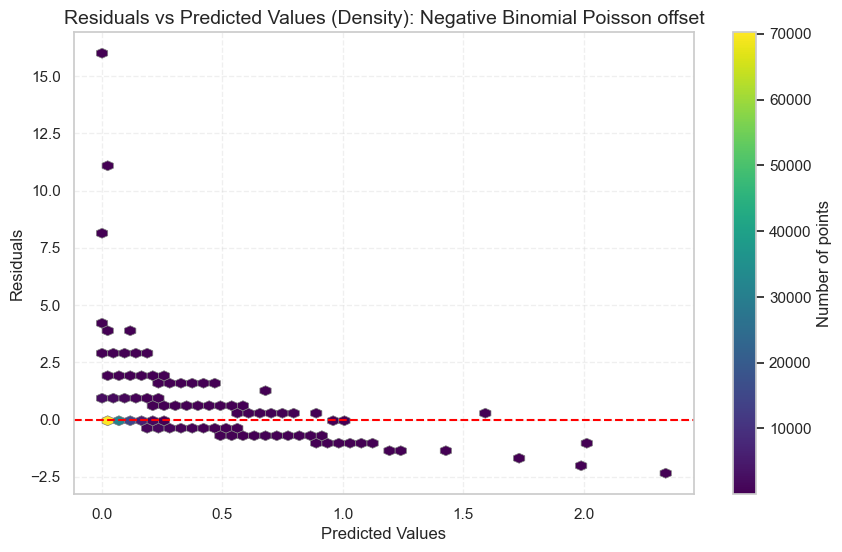

In [19]:
residual_plot(y_true=y_test, y_pred=y_test_pred, name="Negative Binomial Poisson offset")

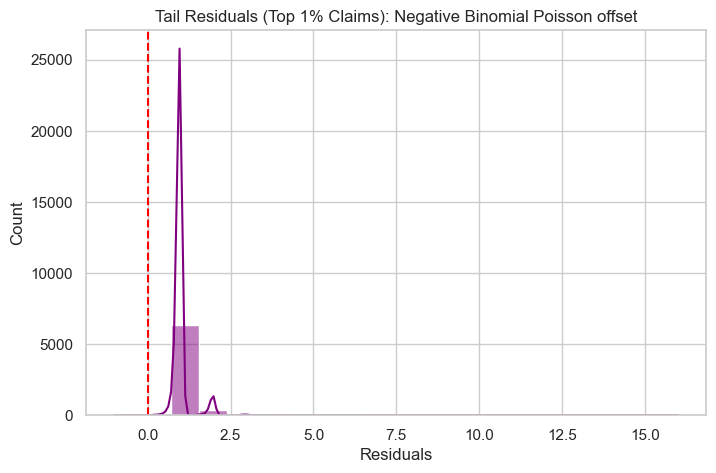

In [20]:
tail_residuals_plot(y_test, y_test_pred, name="Negative Binomial Poisson offset")

d:\ITU\2025-ITU-MachineLearning-Project-Claims-Risk-zrt\src\visualization\model_plots.py:65: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(
d:\ITU\2025-ITU-MachineLearning-Project-Claims-Risk-zrt\src\visualization\model_plots.py:87: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


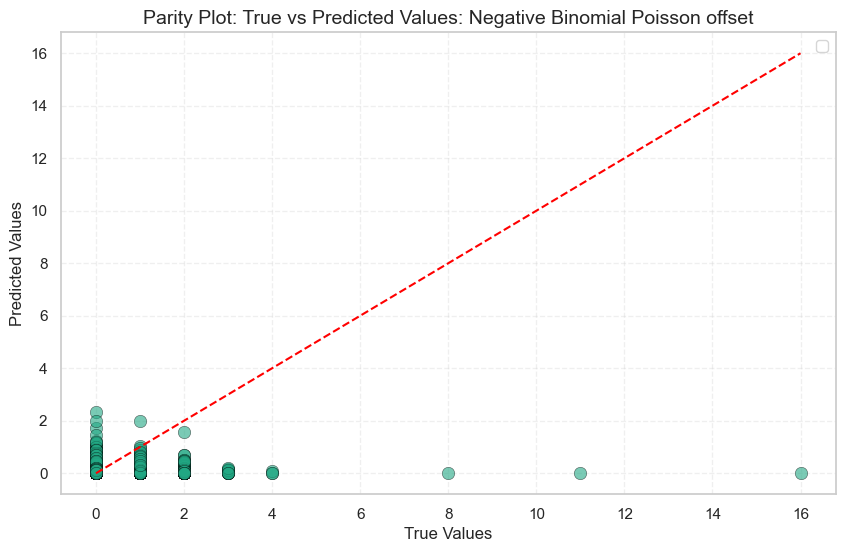

In [21]:
parity_plot(y_true=y_test, y_pred=y_test_pred, name="Negative Binomial Poisson offset")

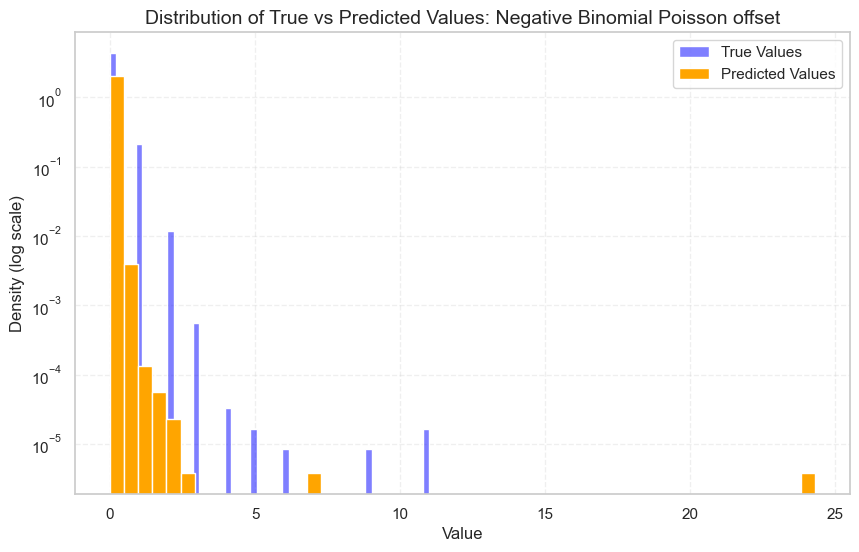

In [22]:
prediction_distribution(y_true=y_train, y_pred=y_train_pred, name="Negative Binomial Poisson offset")

d:\ITU\2025-ITU-MachineLearning-Project-Claims-Risk-zrt\src\visualization\model_plots.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Type', y='Value', data=df_melt, palette=['blue', 'orange'], inner='quartile')


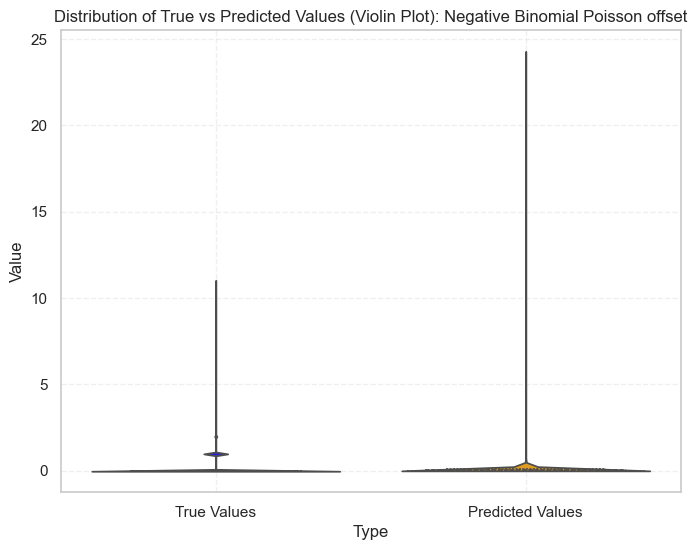

In [23]:
prediction_distribution_violin(y_true=y_train, y_pred=y_train_pred, name="Negative Binomial Poisson offset")

## Saving

In [24]:
joblib.dump(final_model, "../models/final_nb_offset.joblib")

['../models/final_nb_offset.joblib']

## Lets repeat with RMSE as scoring

In [3]:
target = "ClaimRate"
(X_train, y_train), (X_test, y_test) = load_data(raw=False, target=target)

In [4]:
# if not os.path.exists("../models/final_nb_glm.joblib"):
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_rmses = []
fold_devs = []

for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train)):
    X_tr, X_val = X_train[tr_idx], X_train[val_idx]
    y_tr, y_val = y_train[tr_idx], y_train[val_idx]

    model = neg_bin_model(X_tr, y_tr)
    res = model.fit()

    preds = model.predict(X_val)
    alpha = res.scale

    model_dev = negbin_deviance(y_val, preds, alpha)
    fold_devs.append(model_dev)
    fold_rmses.append(rmse(y_val, preds))

    mu_null = np.mean(y_tr)
    null_preds = np.full_like(y_val, mu_null)

    null_dev = negbin_deviance(y_val, null_preds, alpha)

    print(
        f"Fold {fold}: null={null_dev:.3f}, model={model_dev:.3f}, "
        f"impr={(null_dev-model_dev)/null_dev*100:.1f}%"
    )

print("CV NB deviance mean:", np.mean(fold_devs))
print("CV NB deviance std :", np.std(fold_devs))

print("CV RMSE mean:", np.mean(fold_rmses))
print("CV RMSE std :", np.std(fold_rmses))



c:\Users\etiko\anaconda3\envs\torchenv\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Fold 0: null=1.003, model=0.943, impr=6.0%


c:\Users\etiko\anaconda3\envs\torchenv\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Fold 1: null=1.006, model=0.930, impr=7.6%


c:\Users\etiko\anaconda3\envs\torchenv\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Fold 2: null=0.992, model=0.931, impr=6.2%


c:\Users\etiko\anaconda3\envs\torchenv\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Fold 3: null=1.001, model=0.945, impr=5.5%


c:\Users\etiko\anaconda3\envs\torchenv\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Fold 4: null=0.998, model=0.939, impr=5.9%
CV NB deviance mean: 0.9376219130637331
CV NB deviance std : 0.006237227571235402
CV RMSE mean: 2.9048892061805263
CV RMSE std : 0.11529299897908742


In [5]:
if not os.path.exists("../models/final_nb.joblib"):    
    final_model = neg_bin_model(X_train, y_train)
    final_fit = final_model.fit()

c:\Users\etiko\anaconda3\envs\torchenv\lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [6]:
# if a best model is already saved, load it
if os.path.exists("../models/final_nb.joblib"):
    best_model_NB = joblib.load("../models/final_nb.joblib")
else:
    best_model_NB = final_model

## Evaluation on train set

In [7]:
y_train_pred = best_model_NB.predict(X_train)

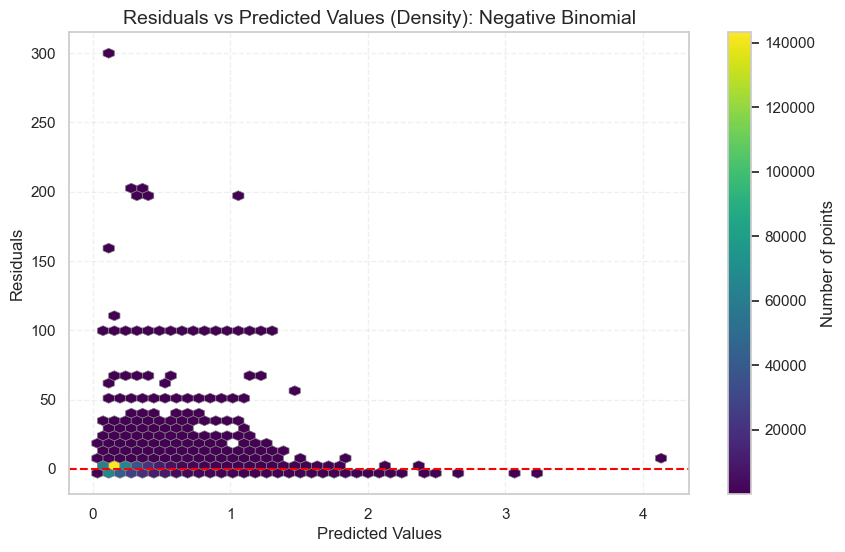

In [8]:
residual_plot(y_true=y_train, y_pred=y_train_pred, name="Negative Binomial")

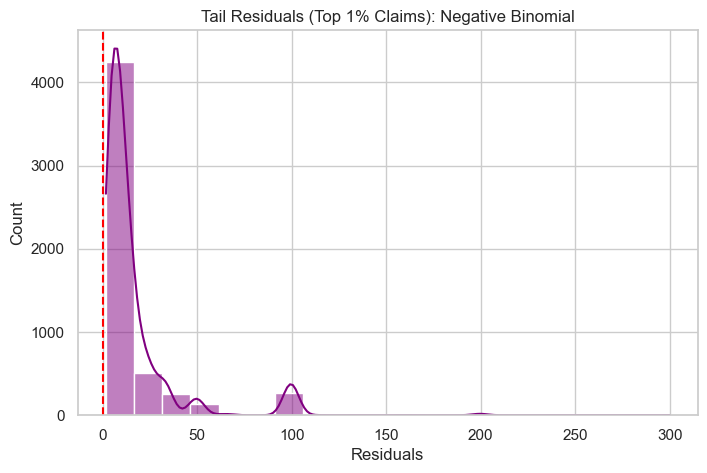

In [9]:
tail_residuals_plot(y_train, y_train_pred, name="Negative Binomial")

d:\ITU\2025-ITU-MachineLearning-Project-Claims-Risk-zrt\src\visualization\model_plots.py:65: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(
d:\ITU\2025-ITU-MachineLearning-Project-Claims-Risk-zrt\src\visualization\model_plots.py:87: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


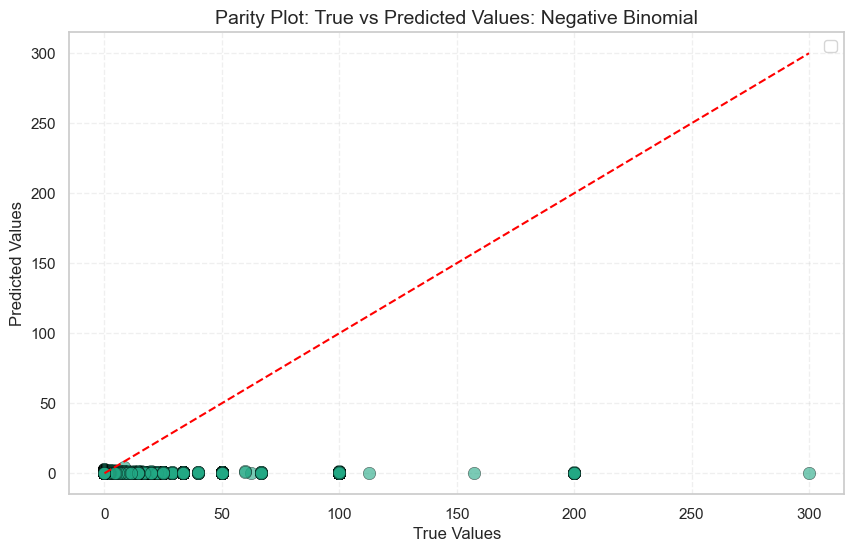

In [10]:
parity_plot(y_true=y_train, y_pred=y_train_pred, name="Negative Binomial")

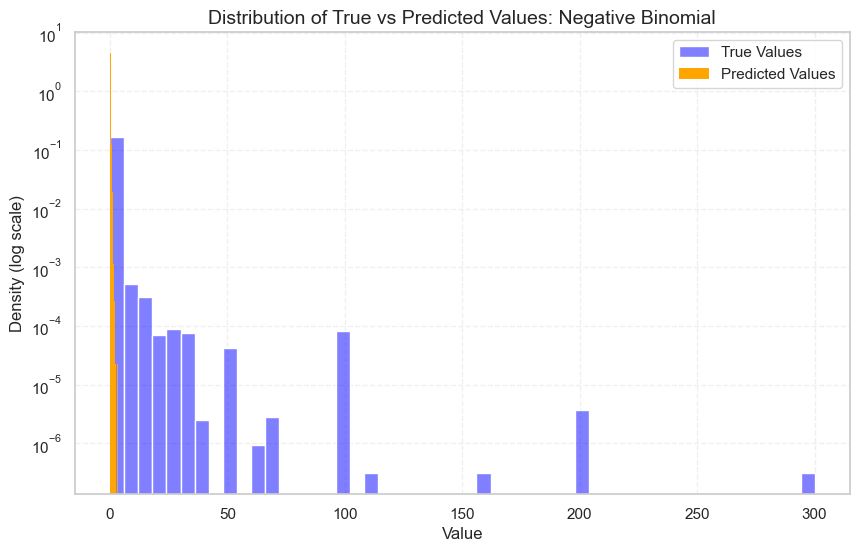

In [11]:
prediction_distribution(y_true=y_train, y_pred=y_train_pred, name="Negative Binomial")

In [ ]:
prediction_distribution_violin(y_true=y_train, y_pred=y_train_pred, name="Negative Binomial")

## Evaluation on test set

In [12]:
y_test_pred = best_model_NB.predict(X_test)

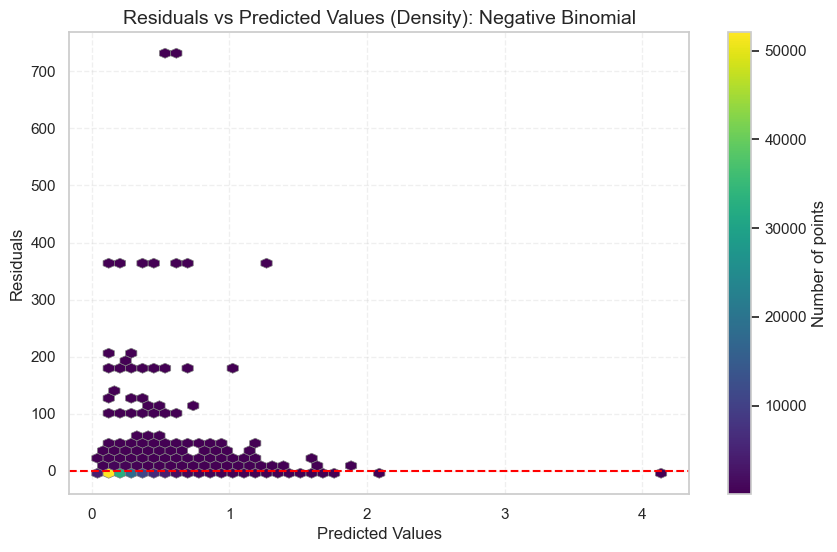

In [13]:
residual_plot(y_true=y_test, y_pred=y_test_pred, name="Negative Binomial")

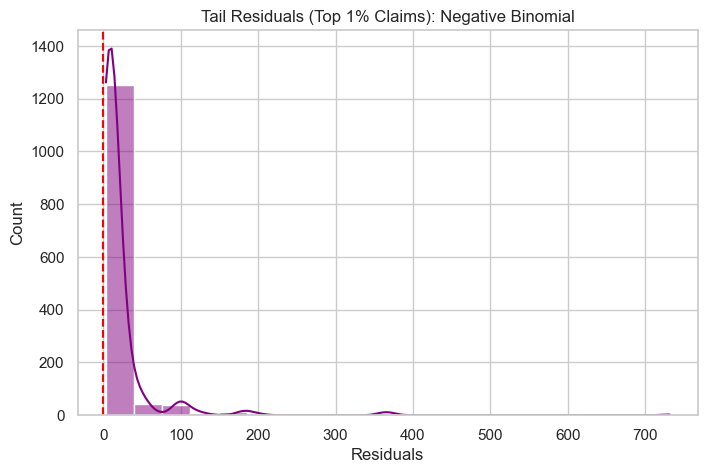

In [14]:
tail_residuals_plot(y_test, y_test_pred, name="Negative Binomial")

d:\ITU\2025-ITU-MachineLearning-Project-Claims-Risk-zrt\src\visualization\model_plots.py:65: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(
d:\ITU\2025-ITU-MachineLearning-Project-Claims-Risk-zrt\src\visualization\model_plots.py:87: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


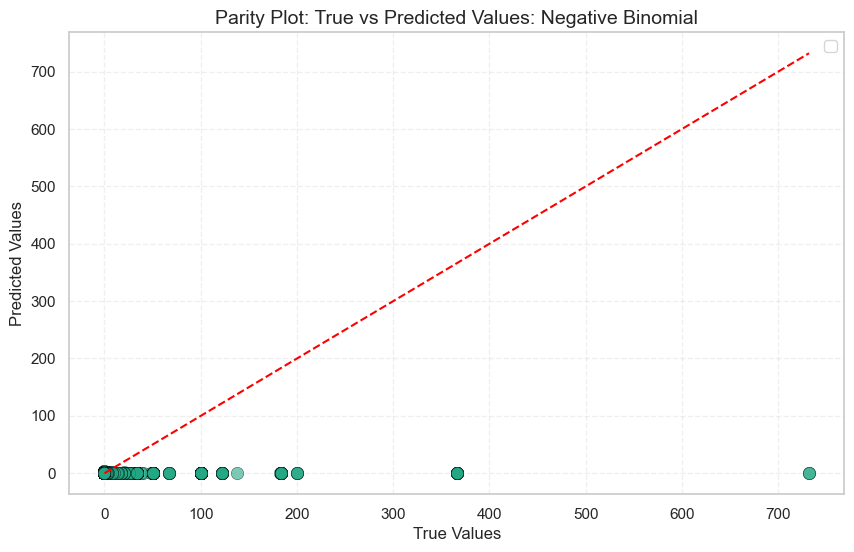

In [15]:
parity_plot(y_true=y_test, y_pred=y_test_pred, name="Negative Binomial")

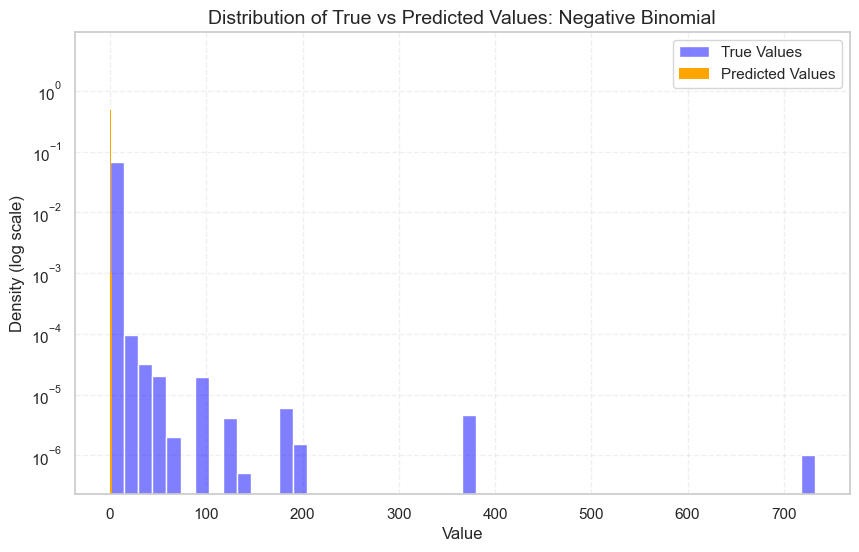

In [16]:
prediction_distribution(y_true=y_test, y_pred=y_test_pred, name="Negative Binomial")

d:\ITU\2025-ITU-MachineLearning-Project-Claims-Risk-zrt\src\visualization\model_plots.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Type', y='Value', data=df_melt, palette=['blue', 'orange'], inner='quartile')


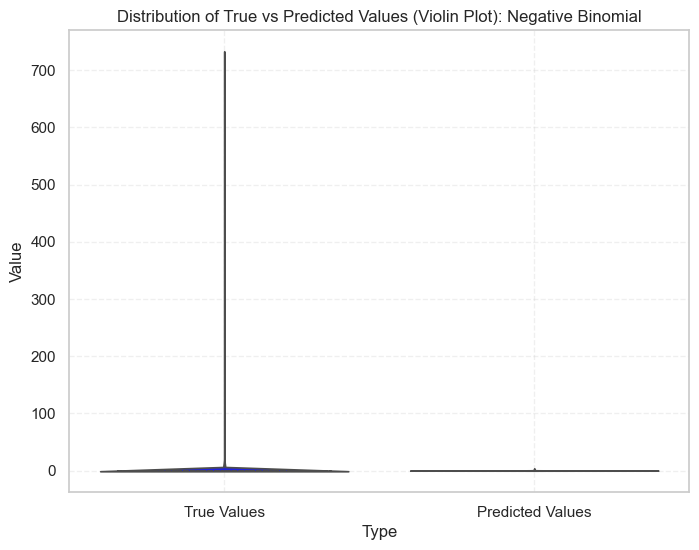

In [17]:
prediction_distribution_violin(y_true=y_test, y_pred=y_test_pred, name="Negative Binomial")

## Saving

In [18]:
joblib.dump(final_model, "../models/final_nb.joblib")

['../models/final_nb.joblib']

## Moving on to RFC

In [30]:
param_grid = {
    "n_estimators": [150, 300],
    "max_depth": [10, 15, 20, None],
    "min_samples_split": [5, 10, 20],
}

n_iter = 24

In [6]:
target = "BinaryClaim"

(X_train, y_train_bin), (X_test, y_test_bin)= load_data(raw=False, target=target)

In [13]:
if not os.path.exists("../models/final_rfc.joblib"):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    best_auc = -np.inf
    best_params = None
    results = []

    for it in range(n_iter):
        params = {
            "n_estimators": random.choice(param_grid["n_estimators"]),
            "max_depth": random.choice(param_grid["max_depth"]),
            "min_samples_split": random.choice(param_grid["min_samples_split"]),
        }

        fold_aucs = []

        print(f"\nIteration {it+1}/{n_iter} | params={params}")

        for fold, (tr_idx, val_idx) in enumerate(kf.split(X_train, y_train_bin)):
            X_tr, X_val = X_train[tr_idx], X_train[val_idx]
            y_tr, y_val = y_train_bin[tr_idx], y_train_bin[val_idx]

            weights = compute_class_weight(
                class_weight="balanced",
                classes=np.array([0, 1]),
                y=y_tr
            )
            class_weight = {0: weights[0], 1: weights[1]}

            model = RFC(
                n_estimators=params["n_estimators"],
                max_depth=params["max_depth"],
                min_samples_split=params["min_samples_split"],
                class_weight=class_weight,
            )

            model.fit(X_tr, y_tr)

            val_probs = model.predict_proba(X_val)
            auc = roc_auc_score(y_val, val_probs)
            fold_aucs.append(auc)

            del model
            gc.collect()

        mean_auc = np.mean(fold_aucs)

        results.append({
            **params,
            "mean_cv_auc": mean_auc
        })

        print(f"  → Mean CV ROC AUC: {mean_auc:.4f}")

        if mean_auc > best_auc:
            best_auc = mean_auc
            best_params = params
            print("  ★ New best model")



Iteration 1/24 | params={'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 10}
  → Mean CV ROC AUC: 0.6372
  ★ New best model

Iteration 2/24 | params={'n_estimators': 150, 'max_depth': None, 'min_samples_split': 20}
  → Mean CV ROC AUC: 0.6357

Iteration 3/24 | params={'n_estimators': 150, 'max_depth': None, 'min_samples_split': 5}
  → Mean CV ROC AUC: 0.6313

Iteration 4/24 | params={'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 5}
  → Mean CV ROC AUC: 0.6326

Iteration 5/24 | params={'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 20}
  → Mean CV ROC AUC: 0.6369

Iteration 6/24 | params={'n_estimators': 150, 'max_depth': 10, 'min_samples_split': 20}
  → Mean CV ROC AUC: 0.6364

Iteration 7/24 | params={'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 20}
  → Mean CV ROC AUC: 0.6413
  ★ New best model

Iteration 8/24 | params={'n_estimators': 300, 'max_depth': 10, 'min_samples_split': 20}
  → Mean CV ROC AUC: 0.6369

Iteration 9/24 | params

In [32]:
if not os.path.exists("../models/final_rfc.joblib"):
    weights = compute_class_weight(
        class_weight="balanced",
        classes=np.array([0, 1]),
        y=y_train_bin
    )
    class_weight = {0: weights[0], 1: weights[1]}

    final_rfc = RFC(
        n_estimators=best_params["n_estimators"],
        max_depth=best_params["max_depth"],
        min_samples_split=best_params["min_samples_split"],
        class_weight=class_weight,
    )

    final_rfc.fit(X_train, y_train_bin)


In [33]:
# if a best model is already saved, load it
if os.path.exists("../models/final_rfc.joblib"):
    best_model_RFC = joblib.load("../models/final_rfc.joblib").model
else:
    best_model_RFC = final_rfc

In [34]:
best_model_RFC.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': {0: 0.526408242252023, 1: 9.966741391349087},
 'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 20,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [35]:
depths = [est.get_depth() for est in best_model_RFC.estimators_]
leaves = [est.get_n_leaves() for est in best_model_RFC.estimators_]

print("Random Forest tree depth:")
print(f"  min={np.min(depths)}  mean={np.mean(depths):.2f}  max={np.max(depths)}")

print("Random Forest number of leaves:")
print(f"  min={np.min(leaves)}  mean={np.mean(leaves):.2f}  max={np.max(leaves)}")

Random Forest tree depth:
  min=15  mean=15.00  max=15
Random Forest number of leaves:
  min=1712  mean=2550.20  max=3851


## Evaluation

ROC AUC      : 0.6531
PR AUC       : 0.1007
Precision    : 0.0933
Recall       : 0.4262


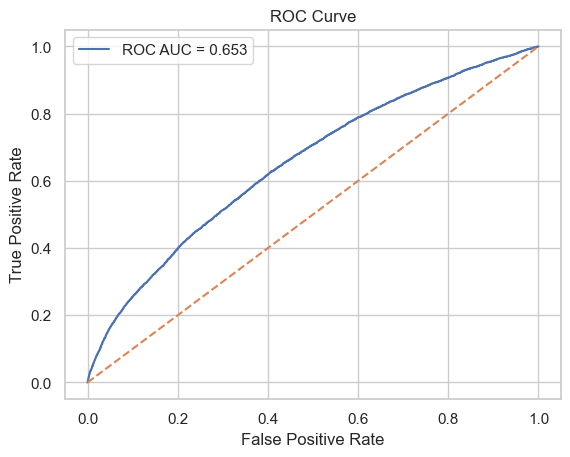

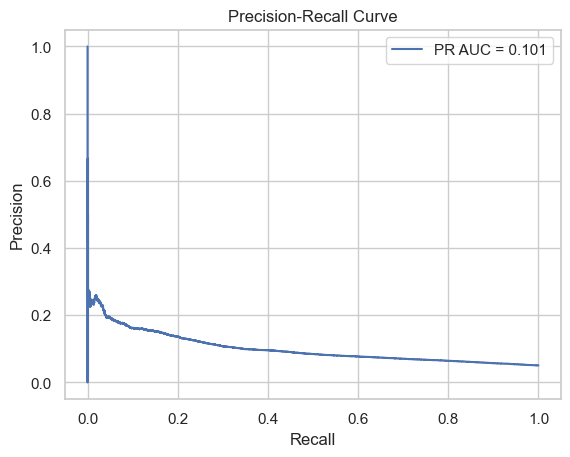

In [56]:
y_prob = best_model_RFC.predict_proba(X_test)[:, 1]
y_pred_test = (y_prob >= 0.5).astype(int)  # default threshold

roc_auc = roc_auc_score(y_test_bin, y_prob)
precision = precision_score(y_test_bin, y_pred_test, pos_label=1)
recall = recall_score(y_test_bin, y_pred_test, pos_label=1)
pr_auc = average_precision_score(y_test_bin, y_prob)

print(f"ROC AUC      : {roc_auc:.4f}")
print(f"PR AUC       : {pr_auc:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")

fpr, tpr, _ = roc_curve(y_test_bin, y_prob)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

precision_curve, recall_curve, _ = precision_recall_curve(y_test_bin, y_prob)

plt.figure()
plt.plot(recall_curve, precision_curve, label=f"PR AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


c:\Users\etiko\anaconda3\envs\torchenv\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator FunctionTransformer from version 1.7.2 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\etiko\anaconda3\envs\torchenv\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator OrdinalEncoder from version 1.7.2 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\etiko\anaconda3\envs\torchenv\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.7.2 when using v

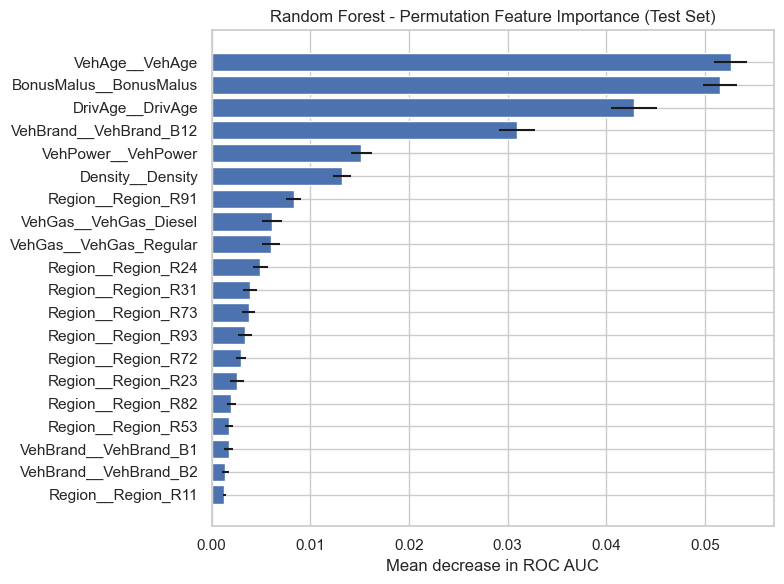

In [43]:
from sklearn.inspection import permutation_importance

preprocesser = joblib.load("../models/preprocesser_BinaryClaim.joblib")

rf = best_model_RFC

# Permutation importance on TEST set
perm = permutation_importance(
    rf,
    X_test,
    y_test_bin,
    n_repeats=10,
    scoring="roc_auc",
    random_state=42,
    n_jobs=-1
)

importances = perm.importances_mean
stds = perm.importances_std
feature_names = preprocesser.get_feature_names_out()

idx = np.argsort(importances)[::-1][:20] # top 20 feats

plt.figure(figsize=(8, 6))
plt.barh(
    feature_names[idx][::-1],
    importances[idx][::-1],
    xerr=stds[idx][::-1]
)
plt.xlabel("Mean decrease in ROC AUC")
plt.title("Random Forest - Permutation Feature Importance (Test Set)")
plt.grid(True, axis="x")
plt.tight_layout()
plt.show()


In [54]:
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train,
    y_train_bin,
    test_size=0.2,
    random_state=42,
    stratify=y_train_bin
)

val_prob = best_model_RFC.predict_proba(X_val)
if val_prob.ndim == 2:
    val_prob = val_prob[:, 1]

fpr, tpr, thr = roc_curve(y_val, val_prob)
j = tpr - fpr
best_thr = thr[np.argmax(j)]

print(f"Chosen threshold from VAL (Youden J): {best_thr:.4f}")

test_prob = best_model_RFC.predict_proba(X_test)
if test_prob.ndim == 2:
    test_prob = test_prob[:, 1]

y_test_pred = (test_prob >= best_thr).astype(int)

Chosen threshold from VAL (Youden J): 0.4790


<Figure size 600x500 with 0 Axes>

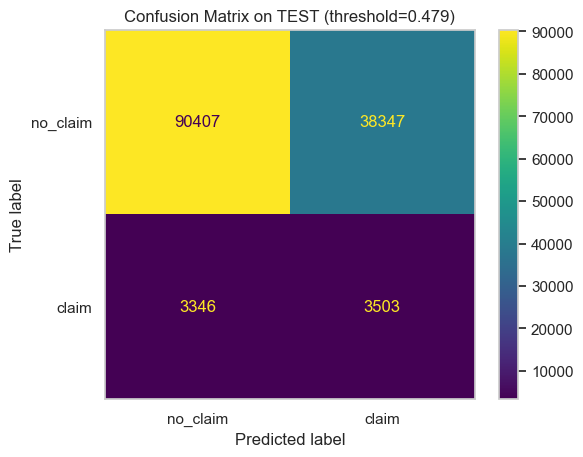

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_bin, y_test_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(cm, display_labels=["no_claim", "claim"])

plt.figure(figsize=(6, 5))
disp.plot(values_format="d")
plt.title(f"Confusion Matrix on TEST (threshold={best_thr:.3f})")
plt.grid(False)
plt.show();

In [ ]:
joblib.dump(final_rfc, "../models/final_rfc.joblib")